### Solution Outline

- 1.Read in image, and convert it to gray scale
- 2.Camera calibrate (grayscale image)
    - find corners
    - compute calibration matrix and distortion
    - correct distortion
- 3.Apply thresholds to create binary image
    - Color: RGB/HLS
    - Gradient: Sobel x/y/mag/grad
- 4.Region Mask
- 5.Perspective transformL
    - identify 4 source points from straight portion of line. 
    - After perspective transform, make bird's eye view perspective

In [143]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os

%matplotlib inline

### 1.Read in image, and convert it to gray scale

In [144]:
path = 'test_images/'
fn = os.listdir(path)

for idx in range(len(fn)):
    print(idx, fn[idx])

0 straight_lines1.jpg
1 straight_lines2.jpg
2 test1.jpg
3 test2.jpg
4 test3.jpg
5 test4.jpg
6 test5.jpg
7 test6.jpg


In [145]:
def readimg(path):
    return mpimg.imread(path)

def get_size(img):
    ysize = image.shape[0]
    xsize = image.shape[1]
    return xsize, ysize

def cvt_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def img_plt(img, ttl=' ',cmap='jet'):
    plt.imshow(img, cmap=cmap)
    plt.title(ttl)
    plt.show()

In [204]:
path_img = path + 'test3.jpg'

# Process image - 1:
image = readimg(path_img)
xsize, ysize = get_size(image)
gray = cvt_gray(image)
# Process image - 1: END

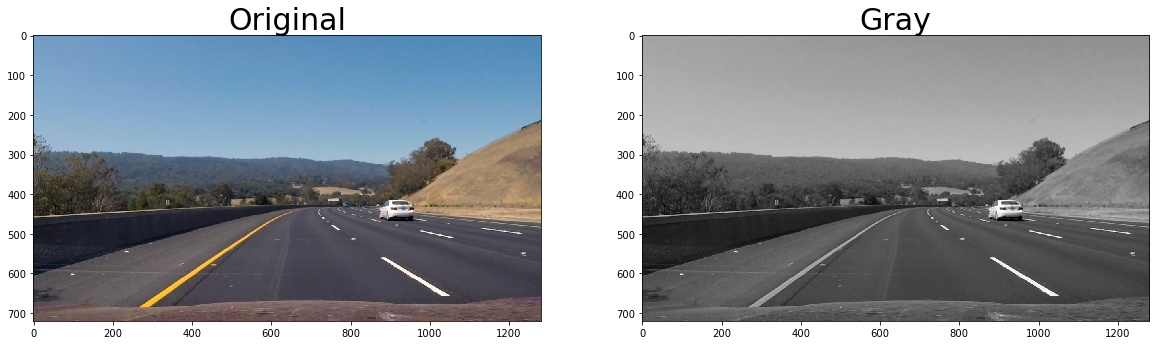

In [205]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray', fontsize=30)
plt.show()

### 2.Camera calibrate (grayscale image) 
### 2.1 One time operation
    - find corners
    - compute calibration matrix and distortion

In [206]:
cal_path = 'camera_cal/'
cal_fn = os.listdir(cal_path)

for idx in range(len(cal_fn)):
    print(idx, cal_fn[idx])

0 .DS_Store
1 calibration1.jpg
2 calibration10.jpg
3 calibration11.jpg
4 calibration12.jpg
5 calibration13.jpg
6 calibration14.jpg
7 calibration15.jpg
8 calibration16.jpg
9 calibration17.jpg
10 calibration18.jpg
11 calibration19.jpg
12 calibration2.jpg
13 calibration20.jpg
14 calibration3.jpg
15 calibration4.jpg
16 calibration5.jpg
17 calibration6.jpg
18 calibration7.jpg
19 calibration8.jpg
20 calibration9.jpg
21 dist_pickle.p


In [207]:
cal_n = 14
path_image_cal = cal_path + cal_fn[cal_n]

# read image
cal_image = readimg(path_image_cal)

In [208]:
# Array to store object points and image points from all the images
nx = 9
ny = 6
def camera_mtx_dist(cal_img, nx=9, ny=6, save_path):
    objpoints = []
    imgpoints = []
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinate

    #Find the chessboard corners
    cal_gray = cvt_gray(cal_img)
    ret, corners = cv2.findChessboardCorners(cal_gray, (nx,ny), None)

    # Visualization
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
       
    # correct distortion
    cal_img_size = (cal_gray.shape[1], cal_gray.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints, cal_img_size,
                                                   None,
                                                   None)
    
    # save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open (save_path + 'dist_pickle.p', 'wb'))
    
    return mtx,dist

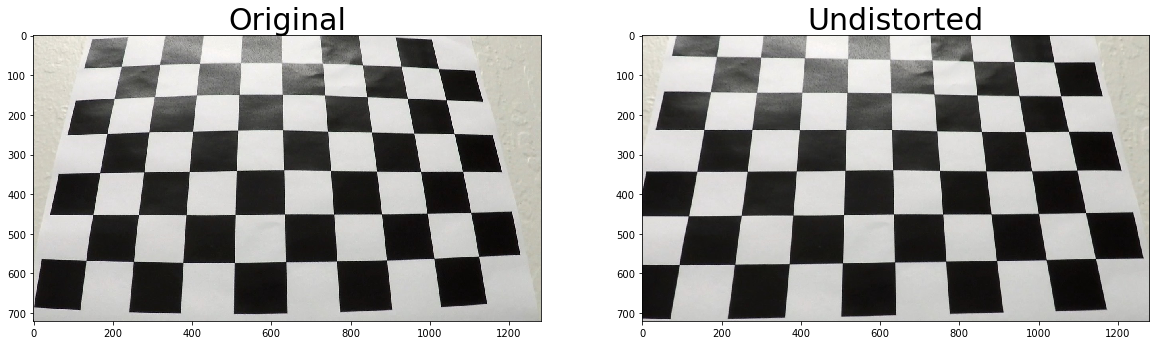

In [209]:
mtx, dist = camera_mtx_dist(cal_image, nx, ny, cal_path)
dst = cv2.undistort(cal_image, mtx, dist, None, mtx)

# visualize undistortion
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(cal_image)
ax1.set_title('Original', fontsize=30)

ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=30)
plt.show()

### 2.2 Undistort Image Using Saved Mtx

In [210]:
# undistort from loaded mtx
def image_undistort(path_pickle, img):
    with open(path_pickle, mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    return cv2.undistort(img, mtx, dist, None, mtx)

In [211]:
path_pickle = 'camera_cal/dist_pickle.p'
undist = image_undistort(path_pickle, image)

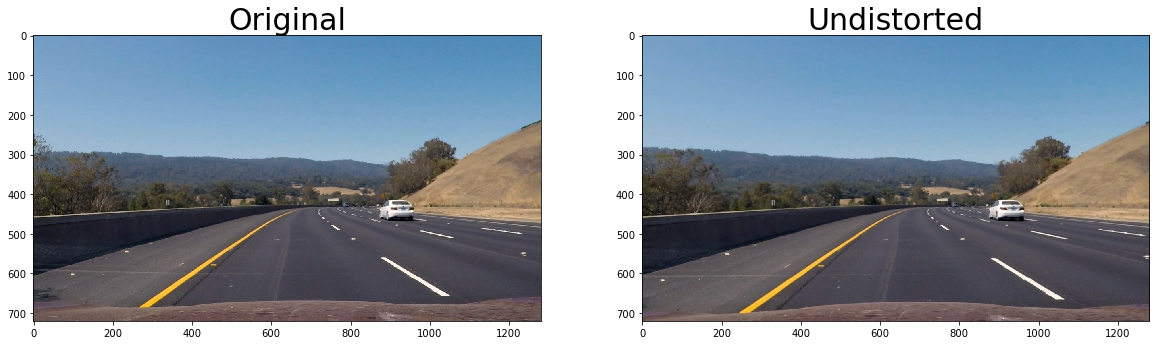

In [212]:
# visualize undistortion
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)

ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=30)
plt.show()

### 3.Apply thresholds to create binary image
    - Color: RGB/HLS
    - Gradient: Sobel x/y/mag/grad
    
### 3.1 Color thresholds

In [213]:
def img_plt(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [214]:
def gray_binary(rgb_img, thresh=(200,255)):
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

def rgb_binary(rgb_img, thresh=(200,255), channel='R'):
    if channel == 'R':
        tmp = rgb_img[:,:,0]
    elif channel == 'G':
        tmp = rgb_img[:,:,1]
    elif channel == 'B':
        tmp = rgb_img[:,:,2]
   
    binary = np.zeros_like(tmp)
    binary[(tmp > thresh[0]) & (tmp <= thresh[1])] = 1
    return binary

def hls_binary(rgb_img, thresh=(100,255), channel='H'):
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    
    if channel == 'H':
        tmp = hls_img[:,:,0]
    elif channel == 'L':
        tmp = hls_img[:,:,1]
    elif channel == 'S':
        tmp = hls_img[:,:,2]
   
    binary = np.zeros_like(tmp)
    binary[(tmp > thresh[0]) & (tmp <= thresh[1])] = 1
    return binary
    

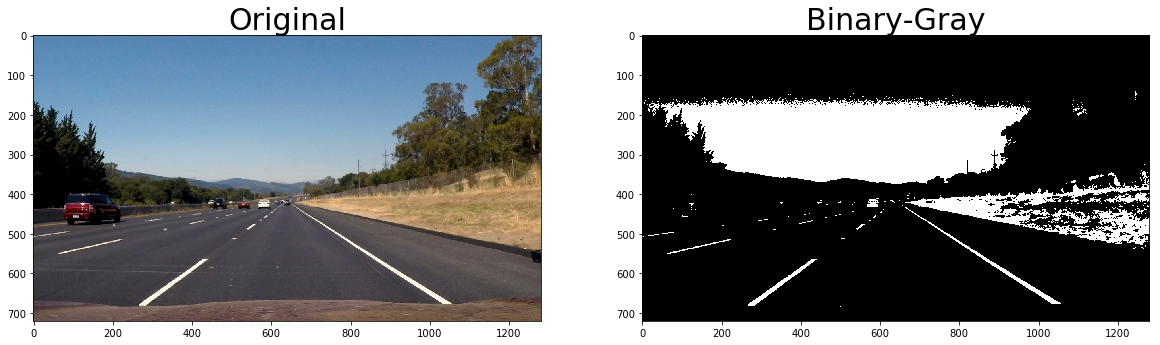

In [307]:
gray_thresh=(150,255)
gry_binary = gray_binary(image, gray_thresh)


f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)

ax2.imshow(gry_binary, cmap='gray')
ax2.set_title('Binary-Gray', fontsize=30)
plt.show()

In [312]:
rgb_thresh = ((200,255),(200,255),(200,255))
r_binary = rgb_binary(image, thresh=rgb_thresh[0], channel='R')
g_binary = rgb_binary(image, thresh=rgb_thresh[1], channel='G')
b_binary = rgb_binary(image, thresh=rgb_thresh[2], channel='B')

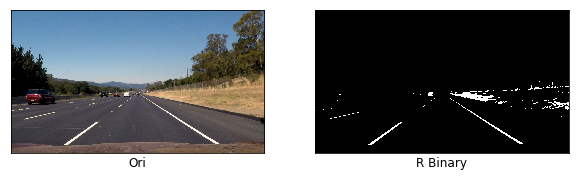

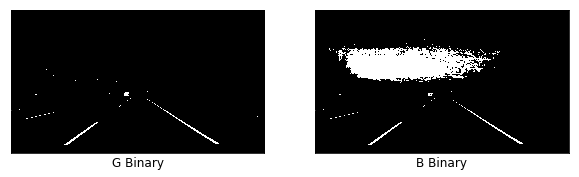

In [313]:
# visualize
plt.figure(figsize=(10,5))
#plt.suptitle('RGB Binary')
plt.subplot(1,2,1)
plt.imshow(image, cmap='jet')
plt.xlabel('Ori', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,2,2)
plt.imshow(r_binary, cmap='gray')
plt.xlabel('R Binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(g_binary, cmap='gray')
plt.xlabel('G Binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,2,2)
plt.imshow(b_binary, cmap='gray')
plt.xlabel('B Binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [310]:
#image = readimg('test_images/test6.jpg')
hls_thresh = ((200,255),(200,255),(200,255))
h_binary = hls_binary(image, thresh=hls_thresh[0], channel='H')
l_binary = hls_binary(image, thresh=hls_thresh[1], channel='L')
s_binary = hls_binary(image, thresh=hls_thresh[2], channel='S')

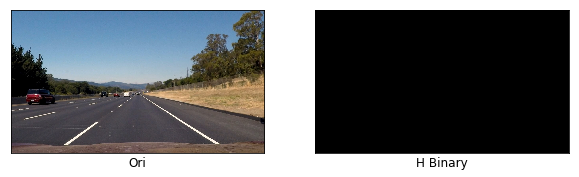

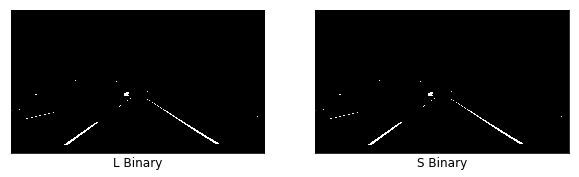

In [311]:
# visualize
plt.figure(figsize=(10,5))
#plt.suptitle('RGB Binary')
plt.subplot(1,2,1)
plt.imshow(image, cmap='jet')
plt.xlabel('Ori', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,2,2)
plt.imshow(h_binary, cmap='gray')
plt.xlabel('H Binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(l_binary, cmap='gray')
plt.xlabel('L Binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,2,2)
plt.imshow(l_binary, cmap='gray')
plt.xlabel('S Binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### 3.2 Gradient

In [220]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20,200)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) &
                  (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary image of ones where threshold is met
    # 0 otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) &
                  (gradmag <= thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2.)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # take the absolute value of the gradient dir
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir>=thresh[0])&
                  (absgraddir<=thresh[1])] = 1
    return binary_output

In [221]:
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(30,100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(30,100))
mag_binary = mag_thresh(image, sobel_kernel=9, thresh=(30,100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7,1.3))

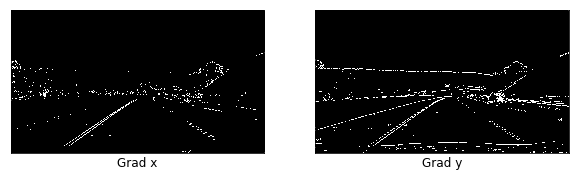

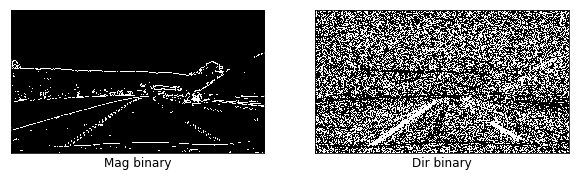

In [222]:
# visualize
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gradx, cmap='gray')
plt.xlabel('Grad x', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,2,2)
plt.imshow(grady, cmap='gray')
plt.xlabel('Grad y', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(mag_binary, cmap='gray')
plt.xlabel('Mag binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,2,2)
plt.imshow(dir_binary, cmap='gray')
plt.xlabel('Dir binary', fontsize=12)
plt.xticks([], [])
plt.yticks([], [])

plt.show()

### 4. Region Mask

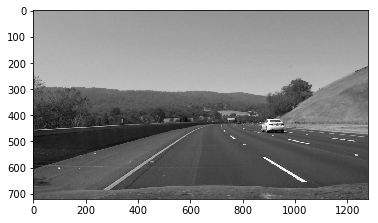

In [223]:
img_plt(gray)

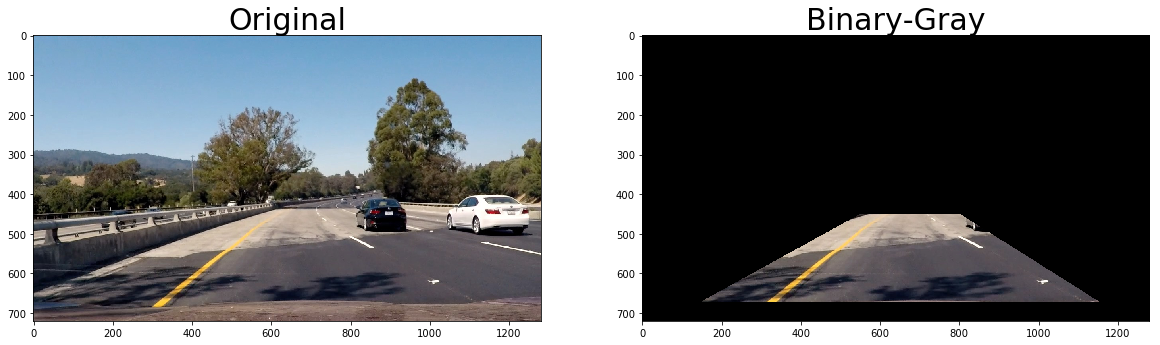

In [315]:
def region_mask(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# read img for testing

image = readimg('test_images/test4.jpg')
gray = cvt_gray(image)
# test function
vertices = np.array([[(150,670), (1150,670),(800,450), (550, 450)]], dtype=np.int32)
img_region = region_mask(image,vertices)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)

ax2.imshow(img_region, cmap='gray')
ax2.set_title('Binary-Gray', fontsize=30)
plt.show()

In [273]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_line_image(image, kernel_size=3):
    # 2 gray scale
    gray = cvt_gray(image)

    # 3 detect edges
    kernel_size = kernel_size
    blur_gray = gaussian_blur(image, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold =220
    threshold = 50
    min_line_length = 50
    max_line_gap = 100
    
    edges = canny(image, low_threshold, high_threshold)

    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180

    #line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    line_image = hough_lines(edges, rho, theta, 
                       threshold, 
                       min_line_length, max_line_gap)
    return line_image

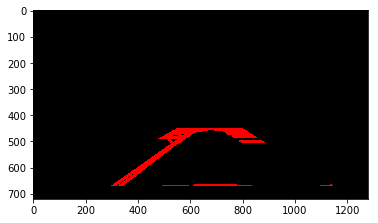

In [275]:
line_image = get_line_image(image, kernel_size = 5)
masked_line_image = region_mask(line_image,vertices)
img_plt(masked_line_image)

### 5.Perspective transform
    - identify 4 source points from straight portion of line. 
    - After perspective transform, make bird's eye view perspective

In [300]:
path = 'test_images/straight_lines1.jpg'
image = mpimg.imread(path)
image.shape

(720, 1280, 3)

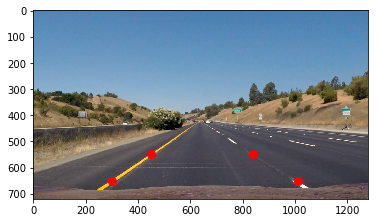

In [301]:
plt.imshow(image)

plt.plot(840,550, 'o', color='red', markersize=8) # top right
plt.plot(1010,650, 'o', color='red', markersize=8) # bottom right
plt.plot(300,650, 'o', color='red', markersize=8) # bottom left
plt.plot(450,550, 'o', color='red', markersize=8) # top left

plt.show()

In [302]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[840,550],[1010,650],[300,650],[450,550]])
    dst = np.float32([[940,520],[940,650],[340,650],[340,520]])  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

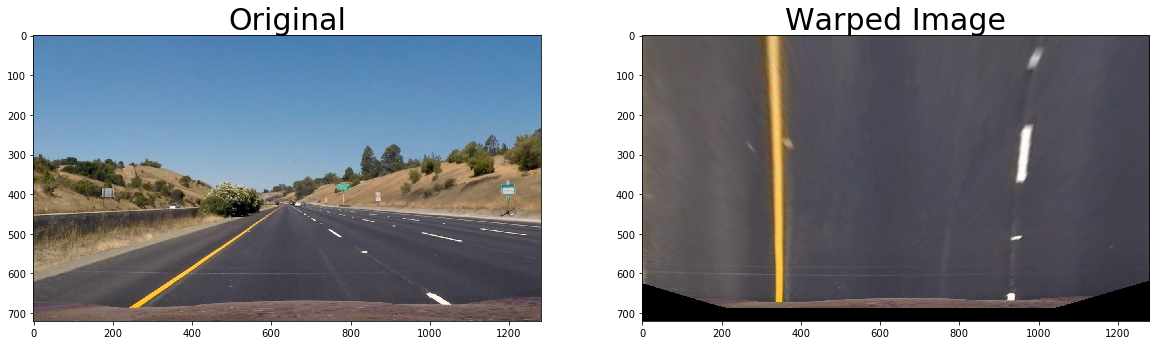

In [303]:
warped = warp(image)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

plt.imsave('test_images_output/test1_output_straight.jpg', warped)

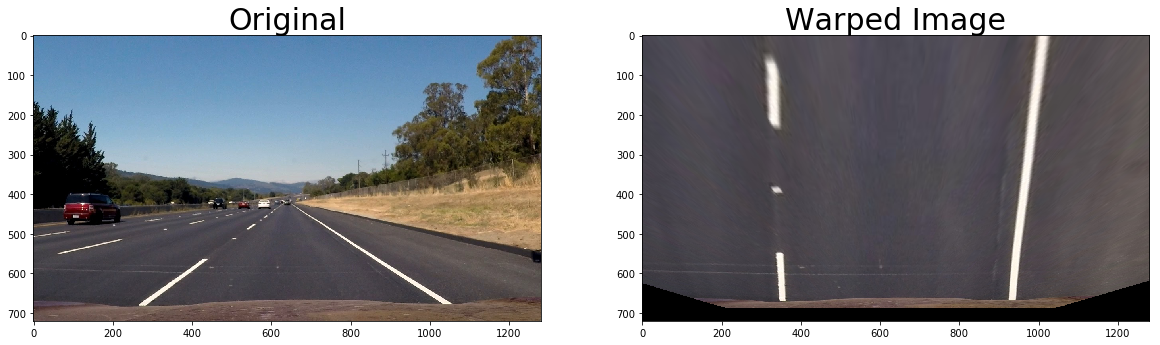

In [304]:
path = 'test_images/straight_lines2.jpg'
image = mpimg.imread(path)
warped = warp(image) 

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

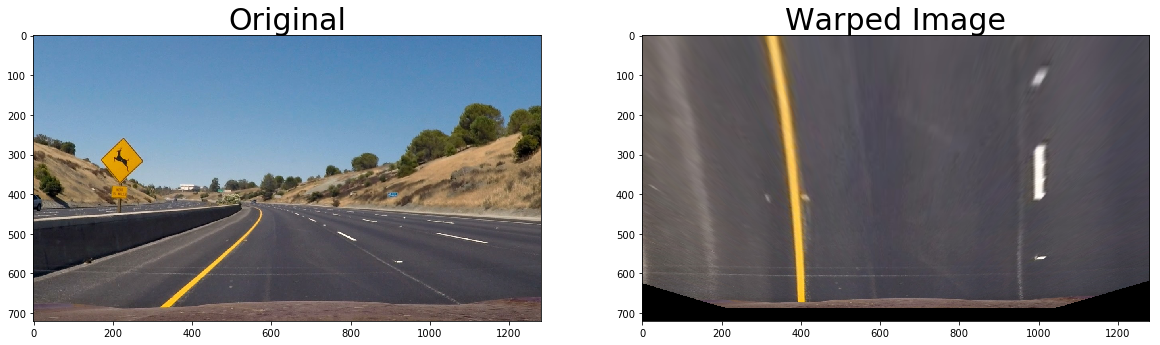

In [296]:
path = 'test_images/test2.jpg'
image = mpimg.imread(path)
warped = warp(image)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

plt.imsave('test_images_output/test2_output_curve_left.jpg', warped)


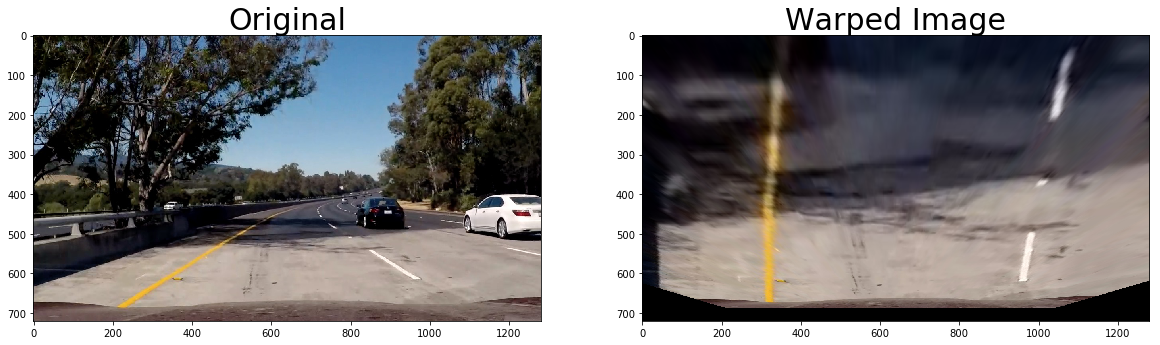

In [299]:
path = 'test_images/test5.jpg'
image = mpimg.imread(path)
warped = warp(image)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

plt.imsave('test_images_output/test5_output_curve_right.jpg', warped)
